In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageDraw
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch

import numpy as np
from src.voc_dataset import *
from src.region_proposal import RegionProposalNetwork, get_target_weights
from src.generate_anchor_data import AnchorDataGenerator
from src.generate_anchors import generate_anchors
from src.anchor_util import generate_all_anchors
from src.proposal import ProposalGenerator
from src.anchor_util import *

import pickle

In [2]:
dataset = VOCDataSet("data/", "train", include_gt_lable=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=5, collate_fn=collate_fn)
iterator = iter(dataloader)

In [3]:
rpn = RegionProposalNetwork()
anchor_generator = AnchorDataGenerator()

In [23]:
image_arr, gt, labels = iterator.next()
image_arr = Variable(image_arr)
gt = Variable(gt)
logits, regressions = rpn(image_arr)

width = Variable(torch.Tensor([logits.size(3)]))
height = Variable(torch.Tensor([logits.size(2)]))
im_w = Variable(torch.Tensor([image_arr.size(3)]))
im_h = Variable(torch.Tensor([image_arr.size(2)]))

labels, bbox_deltas, bbox_weights, l1_loss_norm, anchors, valid_anchor_indices = \
                anchor_generator(width, height, gt, im_w, im_h)
    
labels = labels.data.numpy()
bbox_deltas = bbox_deltas.data.numpy()
bbox_weights = bbox_weights.data.numpy()
anchors = anchors.data.numpy()
valid_anchor_indices = valid_anchor_indices.data.numpy().astype(np.int)

flat_labels = labels.reshape((1, 9, labels.shape[2]/9, labels.shape[3])).transpose(0, 2, 3, 1).ravel()

flat_bbox_weights = bbox_weights.transpose(0, 2, 3, 1)\
                                .reshape((bbox_weights.shape[2]*bbox_weights.shape[3]*9, 4))

not_valid_indices = np.ones_like(flat_labels)
not_valid_indices[valid_anchor_indices] = 0
not_valid_indices = np.where(not_valid_indices == 1)[0]
    
print("--- Valid anchor information")
print("Background: %s" % np.where(flat_labels[valid_anchor_indices] == 0)[0].shape[0])
print("Foreground: %s" % np.where(flat_labels[valid_anchor_indices] == 1)[0].shape[0])
print("Ignore: %s" % np.where(flat_labels[valid_anchor_indices] == 2)[0].shape[0])
print("\n")

print("--- Invalid anchor information")
print("Background: %s" % np.where(flat_labels[not_valid_indices] == 0)[0].shape[0])
print("Foreground: %s" % np.where(flat_labels[not_valid_indices] == 1)[0].shape[0])
print("Ignore: %s" % np.where(flat_labels[not_valid_indices] == 2)[0].shape[0])

assert(len(valid_anchor_indices) + len(not_valid_indices) == flat_labels.shape[0])
assert(flat_bbox_weights[np.where(flat_labels == 0)].sum() == 0)
assert(flat_bbox_weights[np.where(flat_labels == 1)].sum() == \
       np.where(flat_labels[valid_anchor_indices] == 1)[0].shape[0] * 4.0)
assert(flat_bbox_weights[np.where(flat_labels == 2)].sum() == 0)

--- Valid anchor information
Background: 128
Foreground: 39
Ignore: 1206


--- Invalid anchor information
Background: 0
Foreground: 0
Ignore: 2677


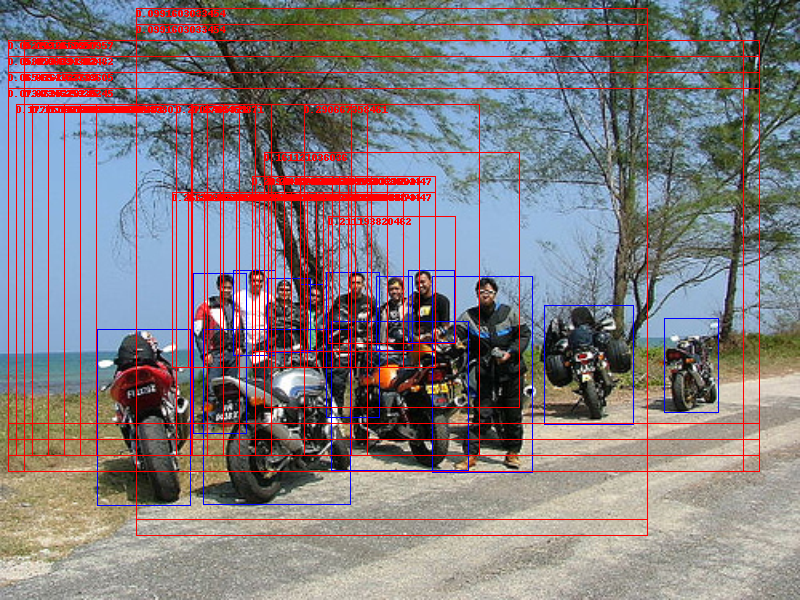

In [24]:
image = image_arr.data.numpy()
image = image * PIXEL_STDS
image = image + PIXEL_MEANS
image = image * 255.0
image = image.squeeze().transpose(1, 2, 0).round().astype(np.uint8)
image = Image.fromarray(image)
image_draw = ImageDraw.ImageDraw(image)

true_bbox = gt.data.numpy()
for i in range(true_bbox.shape[0]):
    image_draw.rectangle(true_bbox[i, :], outline="blue")

overlaps = get_overlap(anchors, true_bbox)[np.where(flat_labels == 1)].max(axis=1)
fg_bbox = anchors[np.where(flat_labels == 1)]
for i in range(fg_bbox.shape[0]):
    image_draw.rectangle(fg_bbox[i, :], outline="red")
    image_draw.text(fg_bbox[i, :2], str(overlaps[i]), fill="red")

image

Problem when IOU is less then NEGATIVE_THRESHOLD, but still marked as FOREGROUND
Suggestion: for each ground-truth box, only mark highest IOU anchors whose IOUs is greater than a certain threshold

In the presence, the multi-purpose loss function is not heavily waited on the regression loss, due to large normalization constant (~128.)
Suggession: make the constant smaller

In [14]:
with open("/home/hnguyen/Wordspace/playground/fail_image.pkl", "w") as f:
    pickle.dump((image_arr.data.numpy(), gt.data.numpy()), f)

--- Valid anchor information
Background: 0
Foreground: 128
Ignore: 1494


--- Invalid anchor information
Background: 0
Foreground: 0
Ignore: 2914


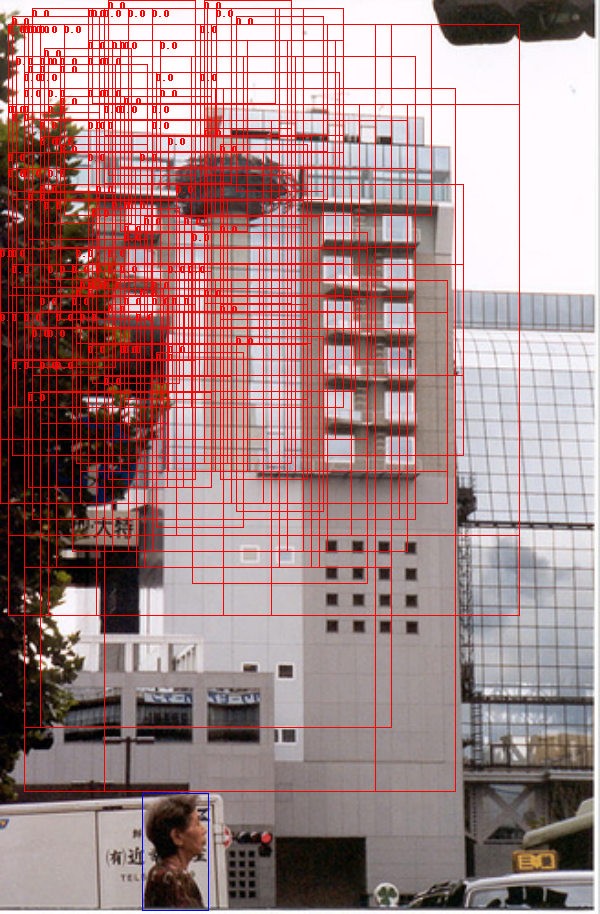

In [44]:
with open("/home/hnguyen/Wordspace/playground/fail_image.pkl", "rb") as f:
    image_arr, gt = pickle.load(f)
    
image_arr = Variable(torch.Tensor(image_arr))
gt = Variable(torch.Tensor(gt))
logits, regressions = rpn(image_arr)

width = Variable(torch.Tensor([logits.size(3)]))
height = Variable(torch.Tensor([logits.size(2)]))
im_w = Variable(torch.Tensor([image_arr.size(3)]))
im_h = Variable(torch.Tensor([image_arr.size(2)]))

labels, bbox_deltas, bbox_weights, l1_loss_norm, anchors, valid_anchor_indices = \
                anchor_generator(width, height, gt, im_w, im_h)
    
labels = labels.data.numpy()
bbox_deltas = bbox_deltas.data.numpy()
bbox_weights = bbox_weights.data.numpy()
anchors = anchors.data.numpy()
valid_anchor_indices = valid_anchor_indices.data.numpy().astype(np.int)

flat_labels = labels.reshape((1, 9, labels.shape[2]/9, labels.shape[3])).transpose(0, 2, 3, 1).ravel()

flat_bbox_weights = bbox_weights.transpose(0, 2, 3, 1)\
                                .reshape((bbox_weights.shape[2]*bbox_weights.shape[3]*9, 4))

not_valid_indices = np.ones_like(flat_labels)
not_valid_indices[valid_anchor_indices] = 0
not_valid_indices = np.where(not_valid_indices == 1)[0]
    
print("--- Valid anchor information")
print("Background: %s" % np.where(flat_labels[valid_anchor_indices] == 0)[0].shape[0])
print("Foreground: %s" % np.where(flat_labels[valid_anchor_indices] == 1)[0].shape[0])
print("Ignore: %s" % np.where(flat_labels[valid_anchor_indices] == 2)[0].shape[0])
print("\n")

print("--- Invalid anchor information")
print("Background: %s" % np.where(flat_labels[not_valid_indices] == 0)[0].shape[0])
print("Foreground: %s" % np.where(flat_labels[not_valid_indices] == 1)[0].shape[0])
print("Ignore: %s" % np.where(flat_labels[not_valid_indices] == 2)[0].shape[0])

assert(len(valid_anchor_indices) + len(not_valid_indices) == flat_labels.shape[0])
assert(flat_bbox_weights[np.where(flat_labels == 0)].sum() == 0)
assert(flat_bbox_weights[np.where(flat_labels == 1)].sum() == \
       np.where(flat_labels[valid_anchor_indices] == 1)[0].shape[0] * 4.0)
assert(flat_bbox_weights[np.where(flat_labels == 2)].sum() == 0)

image = image_arr.data.numpy()
image = image * PIXEL_STDS
image = image + PIXEL_MEANS
image = image * 255.0
image = image.squeeze().transpose(1, 2, 0).round().astype(np.uint8)
image = Image.fromarray(image)
image_draw = ImageDraw.ImageDraw(image)

true_bbox = gt.data.numpy()
for i in range(true_bbox.shape[0]):
    image_draw.rectangle(true_bbox[i, :], outline="blue")

overlaps = get_overlap(anchors, true_bbox)[np.where(flat_labels == 1)].max(axis=1)
fg_bbox = anchors[np.where(flat_labels == 1)]
for i in range(fg_bbox.shape[0]):
    image_draw.rectangle(fg_bbox[i, :], outline="red")
    image_draw.text(fg_bbox[i, :2], str(overlaps[i]), fill="red")

image

In [38]:
shift_x = np.arange(0, 18) * 16
shift_y = np.arange(0, 25) * 16

xs, ys = np.meshgrid(shift_x, shift_y)
xs, ys = xs.ravel(), ys.ravel()
shifts_1 = np.vstack([xs, ys, xs, ys])
shifts_1 = shifts_1[np.newaxis, :].transpose((2, 0, 1))

In [39]:
shifts_1

array([[[  0,   0,   0,   0]],

       [[ 16,   0,  16,   0]],

       [[ 32,   0,  32,   0]],

       ..., 
       [[240, 384, 240, 384]],

       [[256, 384, 256, 384]],

       [[272, 384, 272, 384]]])

In [40]:
shift_x = np.arange(0, 18) * 16
shift_y = np.arange(0, 25) * 16

xs, ys = np.meshgrid(shift_x, shift_y)
xs, ys = xs.ravel(), ys.ravel()
shifts_2 = np.vstack([xs, ys, xs, ys]).transpose()
shifts_2 = shifts_2.reshape((1, shifts_2.shape[0], 4)).transpose((1, 0, 2))

In [43]:
(shifts_2 - shifts_1).sum()

0